## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [ ]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
!pip install scikit-plot
!pip install 'portalocker>=2.0.0'

In [ ]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [ ]:
#Load and format dataset
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [ ]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [ ]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [ ]:
#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [ ]:
#split dataset
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [ ]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [ ]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [ ]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y) - 1

In [ ]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 25 #keeps 25 tokens per text example
BATCH_SIZE = 1024

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [ ]:
 print('Unique Characters:', len(vocab))

Unique Characters: 95811


In [ ]:
EMBEDDING_SIZE = 50 # < number of unique characters
NEURONS = 50
LAYERS = 1
NUM_CLASSES = len(set([label for (label, text) in train_dataset])) # 4 classes

In [ ]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super(RNN_Model_1, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)

        self.rnn = nn.RNN(EMBEDDING_SIZE, hidden_size = EMBEDDING_SIZE, num_layers=LAYERS,batch_first=True) # complete this code/
                        # You may use PyTorch nn.GRU(), nn.RNN(), or nn.LSTM()

        self.fc =  nn.Linear(EMBEDDING_SIZE, NUM_CLASSES)  # complete output classifier layer using linear layer

    def forward(self, x):
      emb = self.embedding_layer(x)
      out, hidden = self.rnn(emb, torch.randn(LAYERS, len(x), NEURONS))
      return self.fc(out[:,-1])
        # implement forward pass. This function will be called when executing the model

In [ ]:
def accuracy(model, loader):
  #specify it doesn't require grad calculations in order to reduce memory consumption
    with torch.no_grad():
      #generates two lists to compare predictions and actual labels
      Y_target, Y_preds = [],[]
      for X, Y in loader:
          preds = model(X)
          Y_target.append(Y)
          Y_preds.append(preds.argmax(dim=-1))
      #concatenates the sequence of tensors
      Y_target = torch.cat(Y_target)
      Y_preds = torch.cat(Y_preds)
      #calculates accuracy using accuracy_score metric
      print("Accuracy: ", str(accuracy_score(Y_target.detach().numpy(), Y_preds.detach().numpy())))

In [ ]:
def train(model, optimiser, epochs=100):
    torch.manual_seed(1)
    #training loop number of epochs times
    for epoch in range(1, epochs+1):
      print("Epoch", str(epoch))
      for X, Y in tqdm(train_loader):
        Y_preds = model(X) #forward pass
        loss = loss_fn(Y_preds, Y) #calculates loss

        optimiser.zero_grad() #clear gradients
        loss.backward() #computes grad of the loss function
        optimiser.step() #updates model params

      accuracy (model, train_loader)

In [ ]:
epochs = 8
lr = 1e-3
# instantiate model, optimiser and loss function
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
train(rnn_model, optimiser=optimiser,  epochs=epochs)

100%|██████████| 106/106 [00:25<00:00,  4.20it/s]


Epoch 1
Accuracy:  0.4646574074074074


100%|██████████| 106/106 [00:15<00:00,  6.74it/s]


Epoch 2
Accuracy:  0.6825555555555556


100%|██████████| 106/106 [00:14<00:00,  7.51it/s]


Epoch 3
Accuracy:  0.7725


100%|██████████| 106/106 [00:14<00:00,  7.47it/s]


Epoch 4
Accuracy:  0.8194907407407407


100%|██████████| 106/106 [00:13<00:00,  7.62it/s]


Epoch 5
Accuracy:  0.8468888888888889


100%|██████████| 106/106 [00:14<00:00,  7.32it/s]


Epoch 6
Accuracy:  0.8661018518518518


100%|██████████| 106/106 [00:13<00:00,  7.69it/s]


Epoch 7
Accuracy:  0.8801481481481481


100%|██████████| 106/106 [00:15<00:00,  6.96it/s]


Epoch 8
Accuracy:  0.8876666666666667


In [ ]:
accuracy(rnn_model, test_loader)

Accuracy:  0.8510526315789474


In [ ]:
def sample_text(model, loader):
  Y_preds, Y_shuffled = [], []
  for X, Y in loader:
    preds = model(X)
    Y_preds.append(preds)
    Y_shuffled.append(Y)
  gc.collect()
  Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

  return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

In [ ]:
actual_labels, pred_labels = sample_text(rnn_model, test_loader)

<Axes: title={'center': 'RNN_1 Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

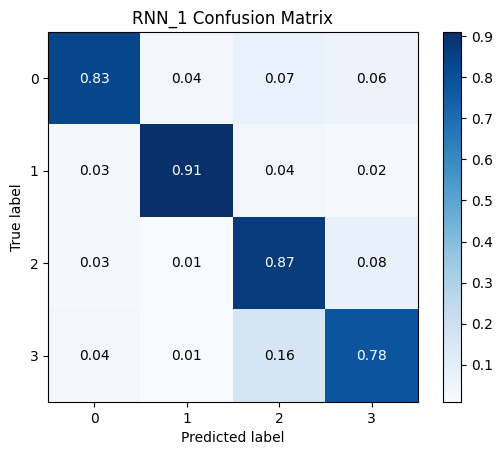

In [ ]:
# create confusion matrix
confusion_matrix_df = confusion_matrix(actual_labels, pred_labels, labels=actual_labels)
skplt.metrics.plot_confusion_matrix(actual_labels, pred_labels, normalize=True,
                                    title="RNN_1 Confusion Matrix")

AG News dataset contains titles and descriptions of news articles from the classes:


*   World
*   Sports
*   Business
*   Sci/Tech

RNNs are designed to work with sequential data, making them a good cantidate to handle NLP problems, where the order in the data is relevant. In particular in text classification, the order of words contains crucial information to understand the content.  

Regular RNNs have limitations such as capturing long term dependencies but we don’t consider necessary for this problem as this dataset does not contain extremely large sequences. For longer sequences we would consider LSTM or GRU, the choice between the neural network depends on the task and the nature of the dataset.


**Bibliography:**
 Raschka, S., Liu, Y. (Hayden), Mirjalili, V., &amp; Dzhulgakov, D. (2022). Machine learning with pytorch and Scikit-Learn: Develop machine learning and deep learning models with python. Packt Publishing.